This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case. \

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction, fitter, plot_utils

flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

Loading the data, located in the package itself



In [3]:
data_velocity = pd.read_parquet(data_path / "data_velocity.parquet")

coordinates_velocity = np.array([data_velocity["ra"], data_velocity["dec"], data_velocity["rcom_zobs"]])

data_velocity_true = {**data_velocity.to_dict(orient='list'), 
                      "velocity_error": np.zeros(len(data_velocity["velocity"].values))}


# Create the data Vector
DataTrueVel = data_vector.DirectVel(data_velocity_true)

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


# Understanding the data

In [4]:
print("Number of simulated SNIa: ", len(data_velocity["ra"]))

Number of simulated SNIa:  518


Plot the position and the velocity of the simulated SNIa, with true velocities, it is possible to see the large-scale velocity modes

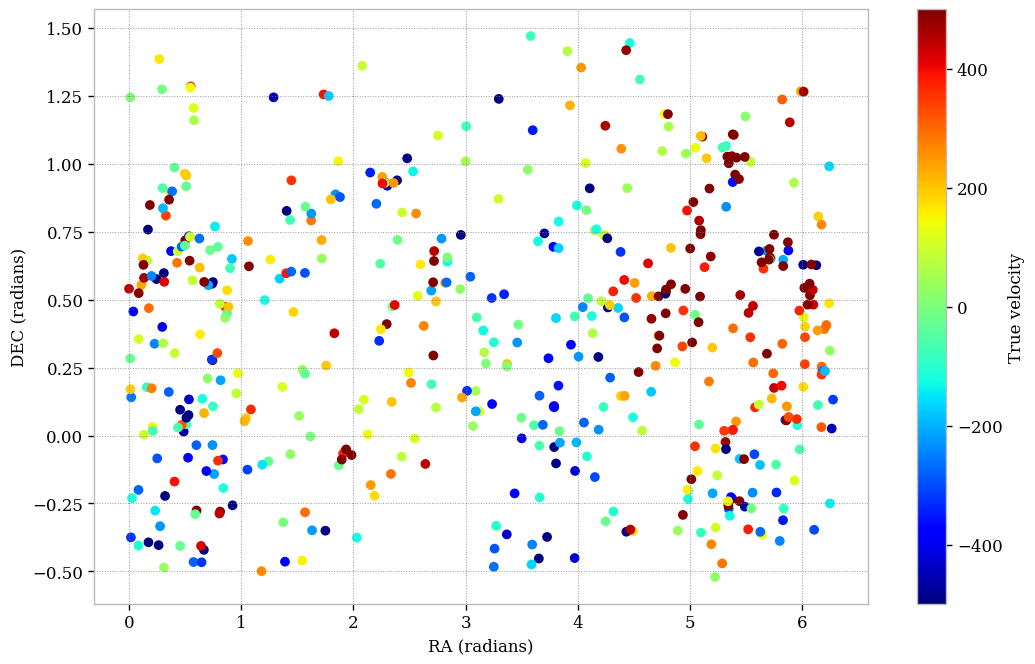

In [5]:
plt.scatter(data_velocity["ra"], data_velocity["dec"],c=data_velocity_true["velocity"],vmin=-500,vmax=500)
plt.xlabel("RA (radians)")
plt.ylabel("DEC (radians)")
cbar = plt.colorbar()
cbar.set_label("True velocity")

In [6]:
print("Available data properties", data_velocity.keys())

Available data properties Index(['mu', 'zobs', 'zCMB', 'zcos', 'como_dist', 'zpcmb', 't0', 'ra', 'dec',
       'vpec', 'min_t', 'max_t', '1_zobs', 'host_index', 'M0', 'coh_sct', 'x1',
       'c', 'alpha', 'beta', 'mw_ebv', 'mw_r_v', 'mb', 'x0', 'e_t0', 'chi2',
       'ndof', 'e_x0', 'e_mb', 'e_x1', 'e_c', 'cov_x0_x1', 'cov_x0_c',
       'cov_mb_x1', 'cov_mb_c', 'cov_x1_c', 'rcom_zobs', 'hubble_norm',
       'velocity', 'velocity_error'],
      dtype='object')


Computation of the Hubble diagram from the fitted properties, this is used during the fitting procedure

Text(0.5, 1.0, 'Hubble diagram')

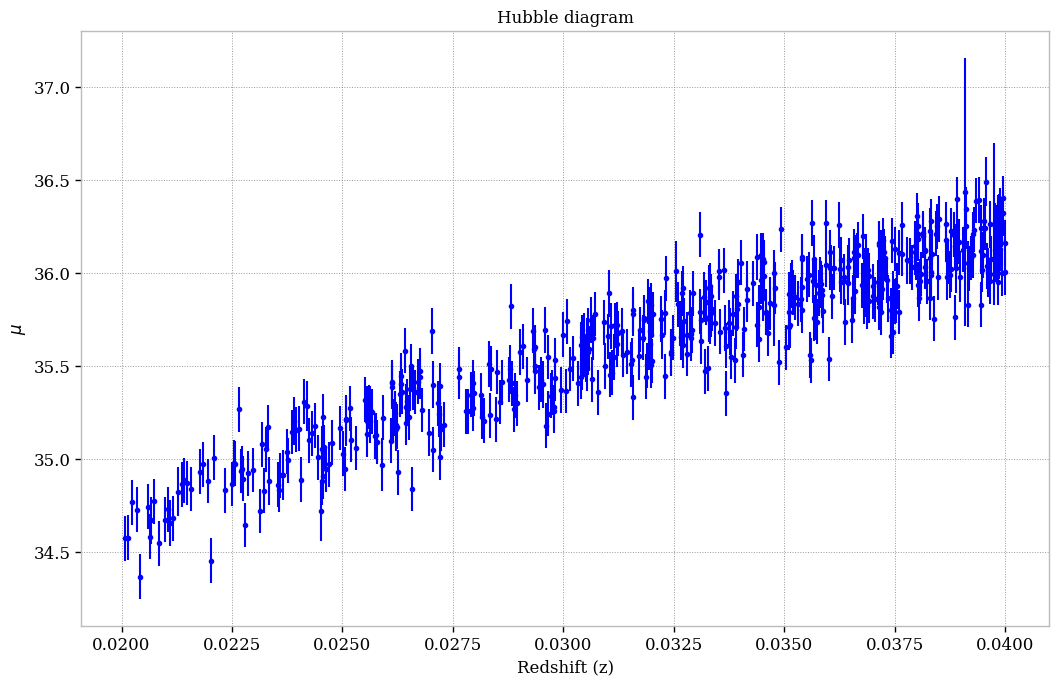

In [7]:
# Load the vector
DataVel = data_vector.snia_vectors.VelFromSALTfit(data_velocity.to_dict(orient='list'), velocity_estimator='full', h=0.70)

test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.01,
                   "sigma_M": 0.12}

mu = DataVel.compute_observed_distance_modulus(test_parameters)
variance_mu = DataVel.compute_observed_distance_modulus_variance(test_parameters)

mask = mu > 0
mask &= np.sqrt(variance_mu) - 0.1* mu < 0

plt.errorbar(DataVel.data["zobs"][mask], 
             mu[mask], 
             np.sqrt(variance_mu)[mask],
             linestyle="None",
             marker=".")

plt.xlabel("Redshift (z)")
plt.ylabel(r"$\mu$")
plt.title("Hubble diagram")

Compute the estimated velocities and errors from the Hubble diagram properties 

Text(0, 0.5, 'Velocity error')

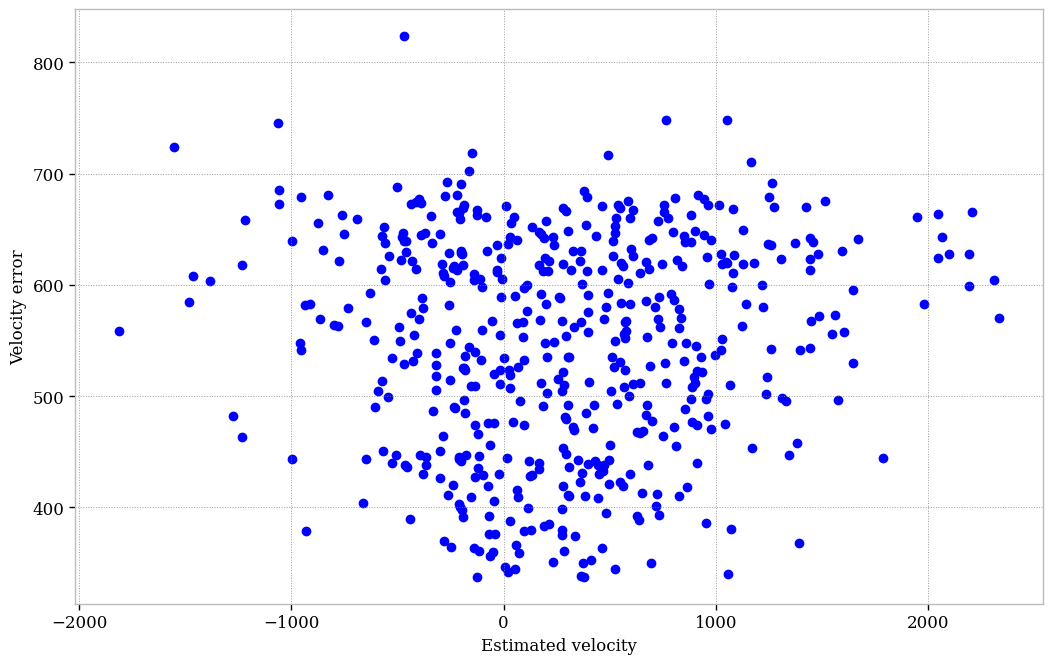

In [8]:
velocity, velocity_var = DataVel.give_data_and_variance(test_parameters)

velocity_error = np.sqrt(velocity_var) 

mask = np.abs(velocity) < 6_000
mask &= velocity_error < 1_000

plt.scatter(velocity[mask], velocity_error[mask])
plt.xlabel("Estimated velocity")
plt.ylabel("Velocity error")

Plot the estimated properties, it is way harder to see the large-scale velocity modes since they are diluted inside the noise 

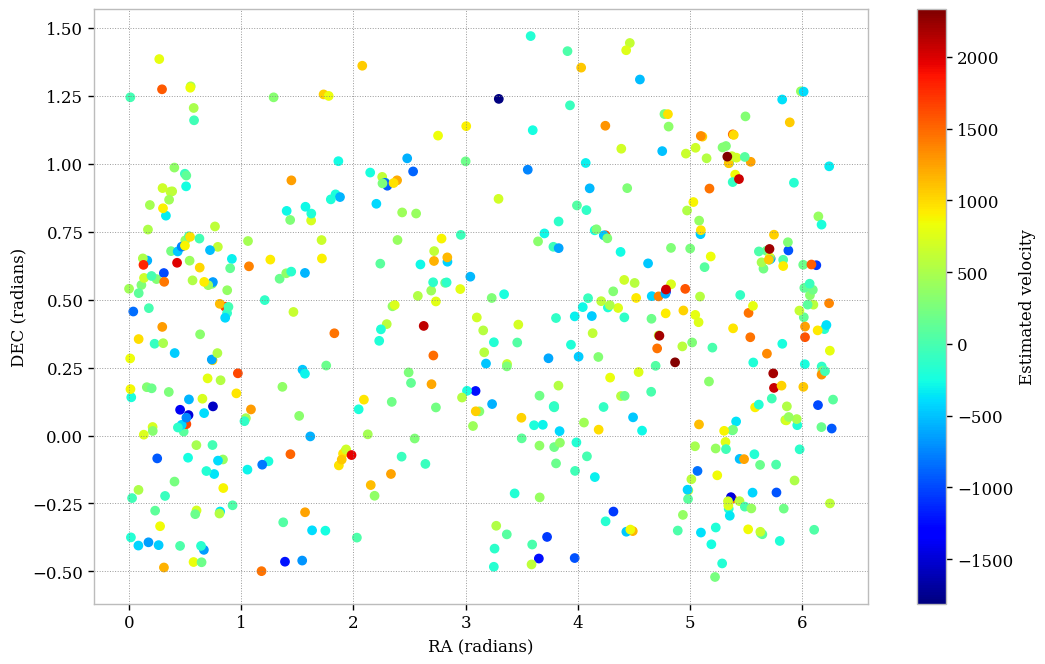

In [9]:
plt.scatter(DataVel.data["ra"][mask], DataVel.data["dec"][mask],c=velocity[mask])

plt.xlabel("RA (radians)")
plt.ylabel("DEC (radians)")
cbar = plt.colorbar()
cbar.set_label("Estimated velocity")


# Fit true velocity

First part of the flip package: fast computation of the covariance matrix based on theory and SNIa coordinates

In [10]:
size_batch=10_000
number_worker=16

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)

/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000033.29 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.06e+00 seconds


Second part of the flip package: compute the likelihood, and start the minuit fitter

In [11]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky"}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }



minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()


Free parameters are: ['sigv', 'fs8']


[ 000034.82 ]: 01-19 02:57  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3778                       │              Nfcn = 56               │
│ EDM = 3.98e-05 (Goal: 0.0001)    │            time = 1.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'fs8': 0.4419669107497538, 'sigv': 328.45503921382334}

# Fit true velocity interpolation sigma_u

In the model, there is a sigma_u parameter which can be interpreted to the smoothing of SNIa position due to peculiar velocities. \
To fit simultaneously this parameter, we interpolate the covariance matrix. 

In [12]:
sigmau_list = np.linspace(10.0, 20.0,10)
covariance_list = []
size_batch=10_000
number_worker=16


for sigu in sigmau_list:
    
    power_spectrum_dict = {"vv": [[ktt, ptt* utils.Du(ktt, sigu)**2]]}

    covariance_list.append(
        covariance.CovMatrix.init_from_flip(
            "carreres23",
            "velocity",
            power_spectrum_dict,
            coordinates_velocity=coordinates_velocity,
            size_batch=size_batch,
            number_worker=number_worker,
        )
    )


[ 000035.81 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.80e-01 seconds
[ 000036.81 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.86e-01 seconds
[ 000037.89 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.07e+00 seconds
[ 000038.97 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.06e+00 seconds
[ 000040.00 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.02e+00 seconds
[ 000040.98 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.68e-01 seconds
[ 000041.99 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.00e+00 seconds
[ 000043.06 ]: 01-19 02:57  root            INFO     Covariance matri

In [13]:
likelihood_type="multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "cholesky", "use_jit": True}

parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigu": {"value": 15.0,
                          "limit_low" : 13.0,
                          "limit_up" : 17.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_interp = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigu",
        interpolation_value_range = sigmau_list,
)

print('Free parameters:', minuit_fitter_interp.likelihood.free_par)

minuit_fitter_interp.run()


Free parameters: ['sigu', 'sigv', 'fs8']


[ 000048.22 ]: 01-19 02:57  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3780                       │              Nfcn = 99               │
│ EDM = 2.94e-06 (Goal: 0.0001)    │            time = 3.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'fs8': 0.4574697460435676,
 'sigv': 329.70243209524114,
 'sigu': 16.99999988079433}

# Fit estimate velocity

Let's first apply some simple masks to remove abherant estimated velocities 

In [14]:
size_batch=10_000
number_worker=16

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)


[ 000049.21 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.87e-01 seconds


In [15]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky"}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "limit_up" : 1.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "limit_up" : 1000,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         }}

minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)

print('Free parameters:', minuit_fitter_velest.likelihood.free_par)

minuit_fitter_velest.run()


/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Free parameters: ['alpha', 'beta', 'M_0', 'sigma_M', 'sigv', 'fs8']


[ 000051.76 ]: 01-19 02:57  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4087                       │              Nfcn = 327              │
│ EDM = 2.64e-05 (Goal: 0.0001)    │            time = 2.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬────────

{'fs8': 0.39661205458028587,
 'sigv': 0.1464638183895709,
 'alpha': 0.1272599795070936,
 'beta': 3.0935765651753626,
 'M_0': -19.062546368841108,
 'sigma_M': 0.14078135365276603}

# Some plots

Plot of the latest covariance matrix computed 

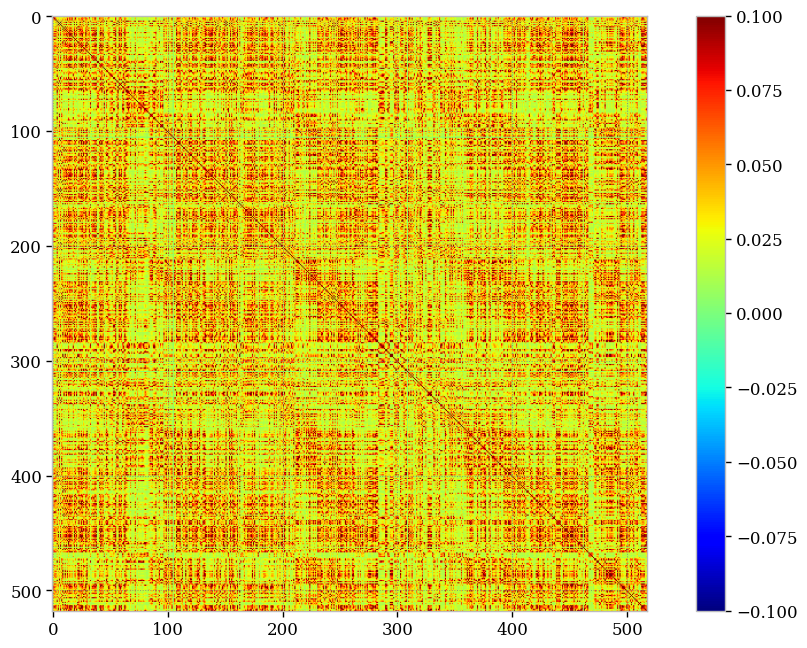

In [16]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter_velest.likelihood,
    parameter_dict,
    vmin=-0.1, vmax=0.1
)

The covariance matrix model can be contracted when we consider parallel and perpendicular separations. \
It allows to see the model more clearly:

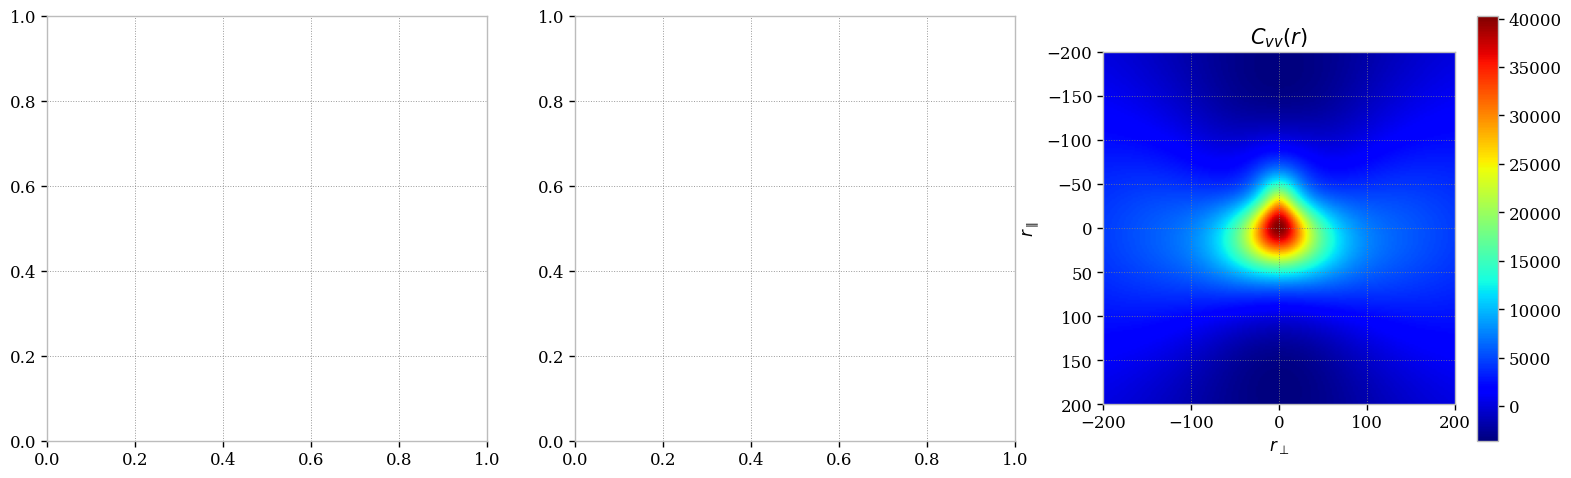

In [17]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)


# MCMC true vel fit

In [18]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {
        "inversion_method": "cholesky", "use_jit": True
        }


parameter_dict = {
        "fs8": {
                "randfun": lambda size: np.random.normal(0.4, 0.001, size=size),
                },
        "sigv": {
                "randfun": lambda size: np.random.normal(200, 10, size=size),
                },
        }


In [19]:
size_batch=10_000
number_worker=16

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)


mcmc_fitter = fitter.FitMCMC.init_from_covariance(
        covariance_fit,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        nwalkers=4
)


[ 000054.37 ]: 01-19 02:57  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.05e+00 seconds


In [20]:
%%time
sampler = mcmc_fitter.sampler.run_chains(100)

CPU times: user 4.23 s, sys: 288 ms, total: 4.52 s
Wall time: 1.62 s
